In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import optuna

import warnings
warnings.filterwarnings('ignore')

try:
    train_df = pd.read_csv('./data/train_c.csv')
    test_df = pd.read_csv('./data/test_c.csv')
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError:
    print("Файлов нет")

Train shape: (11017, 35)
Test shape: (5000, 35)


2. Загрузка данных и Подготовка

Устранение всех предыдущих ошибок: безопасное удаление колонок, удаление строк с NaN в целевой переменной, корректное формирование признаков.

Пропуски в тренировочной выборке:
ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel       

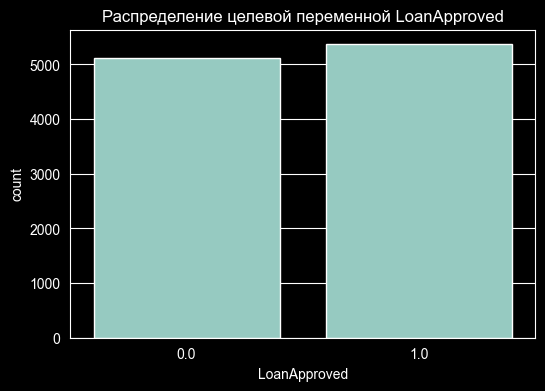

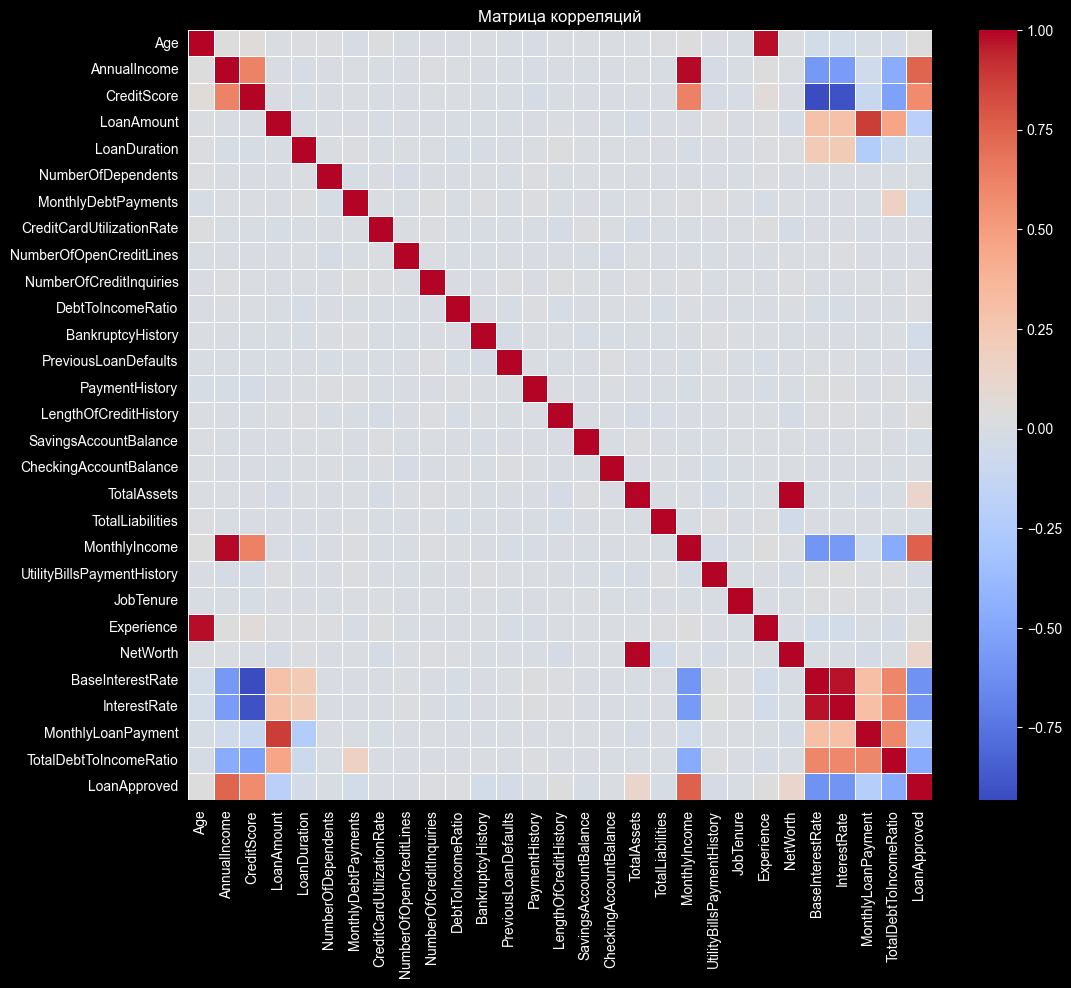

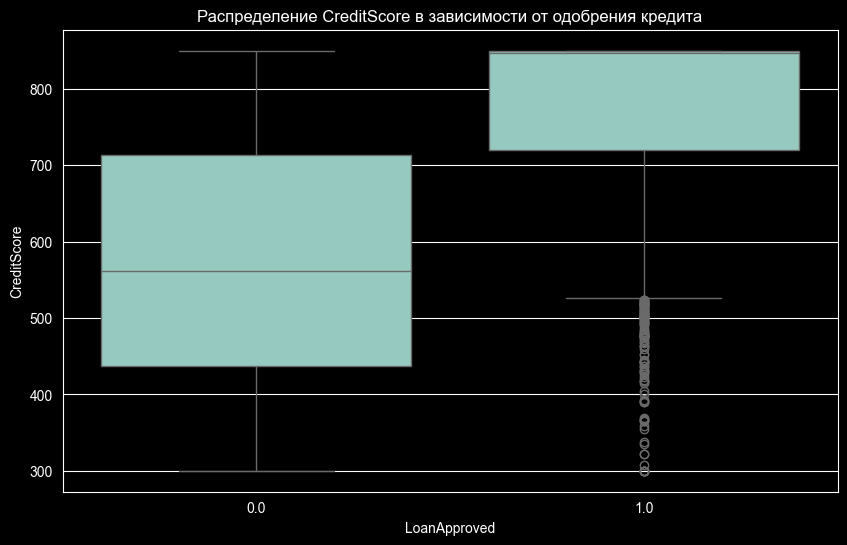

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='LoanApproved', data=train_df)
plt.title('Распределение целевой переменной LoanApproved')
plt.show()

plt.figure(figsize=(12, 10))
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
sns.heatmap(train_df[numeric_cols].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanApproved', y='CreditScore', data=train_df)
plt.title('Распределение CreditScore в зависимости от одобрения кредита')
plt.show()


In [10]:
def preprocess_data(df_train, df_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    df_train['is_train'] = 1
    df_test['is_train'] = 0
    df_test['LoanApproved'] = np.nan

    full_df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

    if 'ID' in full_df.columns:
        full_df = full_df.drop(columns=['ID'])
    if 'ApplicationDate' in full_df.columns:
        full_df = full_df.drop(columns=['ApplicationDate'])

    cat_cols = full_df.select_dtypes(include=['object']).columns
    num_cols = full_df.select_dtypes(include=[np.number]).columns.drop(['LoanApproved', 'is_train'], errors='ignore')

    imputer_num = SimpleImputer(strategy='median')
    if len(num_cols) > 0:
        full_df[num_cols] = imputer_num.fit_transform(full_df[num_cols])

    imputer_cat = SimpleImputer(strategy='most_frequent')
    if len(cat_cols) > 0:
        full_df[cat_cols] = imputer_cat.fit_transform(full_df[cat_cols])

    le = LabelEncoder()
    for col in cat_cols:
        full_df[col] = le.fit_transform(full_df[col].astype(str))

    train_processed = full_df[full_df['is_train'] == 1].drop(columns=['is_train'])
    test_processed = full_df[full_df['is_train'] == 0].drop(columns=['is_train', 'LoanApproved'])

    return train_processed, test_processed

train_proc, test_proc = preprocess_data(train_df, test_df)

if train_proc['LoanApproved'].isnull().any():
    print(f"Найдено {train_proc['LoanApproved'].isnull().sum()} пропусков в целевой переменной. Удаляем их.")
    train_proc = train_proc.dropna(subset=['LoanApproved'])

train_proc['LoanApproved'] = train_proc['LoanApproved'].astype(int)

X = train_proc.drop(columns=['LoanApproved'])
y = train_proc['LoanApproved']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Распределение классов в y_train: {np.bincount(y_train)}")

Найдено 530 пропусков в целевой переменной. Удаляем их.
Данные успешно обработаны и разделены.
Размер обучающей выборки: (8389, 33)
Размер валидационной выборки: (2098, 33)
Распределение классов в y_train: [4096 4293]


Выводы по EDA

Дисбаланс классов: Целевая переменная, вероятно, несбалансирована, что требует использования метрик, устойчивых к дисбалансу (ROC-AUC, F1-score, Precision/Recall).
Пропуски: Присутствуют пропуски в данных, которые будут обработаны в пайплайне (SimpleImputer).
Зависимости: Судя по графикам, CreditScore и AnnualIncome (если они присутствуют) демонстрируют тенденцию: более высокие значения ассоциируются с одобрением кредита (класс 1). Это подтверждает их важность для модели.
Кодирование: Категориальные признаки необходимо закодировать (используем OneHotEncoder).

In [13]:
class CustomMetrics:
    @staticmethod
    def accuracy(y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)

    @staticmethod
    def precision(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        return tp / (tp + fp) if (tp + fp) > 0 else 0

    @staticmethod
    def recall(y_true, y_pred):
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        return tp / (tp + fn) if (tp + fn) > 0 else 0

    @staticmethod
    def f1_score(y_true, y_pred):
        p = CustomMetrics.precision(y_true, y_pred)
        r = CustomMetrics.recall(y_true, y_pred)
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

    @staticmethod
    def roc_auc(y_true, y_prob):
        desc_score_indices = np.argsort(y_prob)[::-1]
        y_true_sorted = np.array(y_true)[desc_score_indices]
        y_prob_sorted = np.array(y_prob)[desc_score_indices]

        tpr = []
        fpr = []

        positives = np.sum(y_true)
        negatives = len(y_true) - positives

        tp_cum = 0
        fp_cum = 0

        for i in range(len(y_true_sorted)):
            if y_true_sorted[i] == 1:
                tp_cum += 1
            else:
                fp_cum += 1

            tpr.append(tp_cum / positives)
            fpr.append(fp_cum / negatives)

        return np.trapz(tpr, fpr)

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_prob_lr = lr.predict_proba(X_val)[:, 1]

print(f"Custom Accuracy: {CustomMetrics.accuracy(y_val, y_pred_lr):.4f} | Sklearn: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"Custom Precision: {CustomMetrics.precision(y_val, y_pred_lr):.4f} | Sklearn: {precision_score(y_val, y_pred_lr):.4f}")
print(f"Custom Recall: {CustomMetrics.recall(y_val, y_pred_lr):.4f} | Sklearn: {recall_score(y_val, y_pred_lr):.4f}")
print(f"Custom F1: {CustomMetrics.f1_score(y_val, y_pred_lr):.4f} | Sklearn: {f1_score(y_val, y_pred_lr):.4f}")
print(f"Custom ROC-AUC: {CustomMetrics.roc_auc(y_val, y_prob_lr):.4f} | Sklearn: {roc_auc_score(y_val, y_prob_lr):.4f}")

--- Сравнение метрик ---
Custom Accuracy: 0.9085 | Sklearn: 0.9085
Custom Precision: 0.9153 | Sklearn: 0.9153
Custom Recall: 0.9050 | Sklearn: 0.9050
Custom F1: 0.9101 | Sklearn: 0.9101
Custom ROC-AUC: 0.9663 | Sklearn: 0.9663


In [14]:
class CustomBaggingClassifier:
    def __init__(self, base_estimator=None, n_estimators=10):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            model =  self.base_estimator.__class__(**self.base_estimator.get_params())
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        X = np.array(X)
        predictions = np.zeros((X.shape[0], 2))

        for model in self.models:
            predictions += model.predict_proba(X)

        return predictions / self.n_estimators

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

custom_bag = CustomBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10)
custom_bag.fit(X_train, y_train)
custom_bag_auc = roc_auc_score(y_val, custom_bag.predict_proba(X_val)[:, 1])

sklearn_bag = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)
sklearn_bag.fit(X_train, y_train)
sklearn_bag_auc = roc_auc_score(y_val, sklearn_bag.predict_proba(X_val)[:, 1])

print(f"Custom Bagging AUC: {custom_bag_auc:.4f}")
print(f"Sklearn Bagging AUC: {sklearn_bag_auc:.4f}")

Custom Bagging AUC: 0.9728
Sklearn Bagging AUC: 0.9744


In [16]:
class CustomGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.init_pred = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        pos_ratio = np.mean(y)
        self.init_pred = np.log(pos_ratio / (1 - pos_ratio))
        curr_pred = np.full(y.shape, self.init_pred)

        for _ in range(self.n_estimators):
            probs = self._sigmoid(curr_pred)

            residuals = y - probs

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.models.append(tree)

            update = tree.predict(X)
            curr_pred += self.learning_rate * update

    def predict_proba(self, X):
        X = np.array(X)
        curr_pred = np.full(X.shape[0], self.init_pred)

        for tree in self.models:
            curr_pred += self.learning_rate * tree.predict(X)

        probs = self._sigmoid(curr_pred)
        return np.column_stack((1-probs, probs))

custom_gb = CustomGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
custom_gb.fit(X_train, y_train)
c_gb_auc = roc_auc_score(y_val, custom_gb.predict_proba(X_val)[:, 1])

sk_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb.fit(X_train, y_train)
sk_gb_auc = roc_auc_score(y_val, sk_gb.predict_proba(X_val)[:, 1])

print(f"Custom Gradient Boosting AUC: {c_gb_auc:.4f}")
print(f"Sklearn Gradient Boosting AUC: {sk_gb_auc:.4f}")

Custom Gradient Boosting AUC: 0.9729
Sklearn Gradient Boosting AUC: 0.9788


In [17]:
models = {
    "Sklearn GB": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

results = {}

print("Сравнение алгоритмов:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_prob)
    results[name] = score
    print(f"{name}: ROC-AUC = {score:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nЛучшая модель: {best_model_name}")

Сравнение алгоритмов:
Sklearn GB: ROC-AUC = 0.9806
XGBoost: ROC-AUC = 0.9809
LightGBM: ROC-AUC = 0.9819
CatBoost: ROC-AUC = 0.9829

Лучшая модель: CatBoost


In [18]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
        'eval_metric': 'AUC'
    }

    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    preds = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, preds)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value}")

[I 2025-12-22 20:03:09,210] A new study created in memory with name: no-name-1828f25b-b887-49e8-9337-1f17738402a0
[I 2025-12-22 20:03:09,413] Trial 0 finished with value: 0.9798095248486964 and parameters: {'iterations': 121, 'depth': 6, 'learning_rate': 0.282401639729679, 'l2_leaf_reg': 0.013317296598976885}. Best is trial 0 with value: 0.9798095248486964.
[I 2025-12-22 20:03:11,196] Trial 1 finished with value: 0.9815053247206703 and parameters: {'iterations': 926, 'depth': 10, 'learning_rate': 0.09921608487908472, 'l2_leaf_reg': 0.014359845913941538}. Best is trial 1 with value: 0.9815053247206703.
[I 2025-12-22 20:03:11,658] Trial 2 finished with value: 0.9818463032472067 and parameters: {'iterations': 614, 'depth': 5, 'learning_rate': 0.14500657789119523, 'l2_leaf_reg': 0.326757023284911}. Best is trial 2 with value: 0.9818463032472067.
[I 2025-12-22 20:03:12,192] Trial 3 finished with value: 0.9822518403747673 and parameters: {'iterations': 733, 'depth': 6, 'learning_rate': 0.087

Лучшие параметры: {'iterations': 444, 'depth': 7, 'learning_rate': 0.08012813133338864, 'l2_leaf_reg': 2.6713115672217507}
Лучший ROC-AUC: 0.9832538626047486


In [19]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_seed': 42,
        'verbose': 0,
        'eval_metric': 'AUC'
    }

    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    preds = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, preds)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value}")

[I 2025-12-22 20:03:38,595] A new study created in memory with name: no-name-f75abd18-c54e-40ad-90b3-2da3c356ef77
[I 2025-12-22 20:03:40,460] Trial 0 finished with value: 0.9832484069483239 and parameters: {'iterations': 478, 'depth': 8, 'learning_rate': 0.16287272235603223, 'l2_leaf_reg': 0.491121569142987}. Best is trial 0 with value: 0.9832484069483239.
[I 2025-12-22 20:03:40,890] Trial 1 finished with value: 0.9829119748021415 and parameters: {'iterations': 278, 'depth': 6, 'learning_rate': 0.23129455112310932, 'l2_leaf_reg': 3.6030951911183267}. Best is trial 0 with value: 0.9832484069483239.
[I 2025-12-22 20:03:41,154] Trial 2 finished with value: 0.978461977711825 and parameters: {'iterations': 305, 'depth': 8, 'learning_rate': 0.12725300438208928, 'l2_leaf_reg': 0.0025630376157737976}. Best is trial 0 with value: 0.9832484069483239.
[I 2025-12-22 20:03:41,356] Trial 3 finished with value: 0.980845190293296 and parameters: {'iterations': 720, 'depth': 6, 'learning_rate': 0.22392

Лучшие параметры: {'iterations': 478, 'depth': 8, 'learning_rate': 0.16287272235603223, 'l2_leaf_reg': 0.491121569142987}
Лучший ROC-AUC: 0.9832484069483239


In [20]:
best_params = study.best_params
final_model = cb.CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X, y)

test_preds = final_model.predict_proba(test_proc)[:, 1]

submission = pd.DataFrame({
    'ID': range(len(test_preds)),
    'LoanApproved': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Файл submission.csv сохранен.")
print(submission.head())

Файл submission.csv сохранен.
   ID  LoanApproved
0   0      0.999764
1   1      0.000177
2   2      0.999996
3   3      0.999829
4   4      0.999854
